# Marching Cubes Exercise

This exercise is all about reconstructing meshes from voxelized data.
In the case of this exercise voxelized data means that we have a 3D grid with assosiated scalar values of the Signed Distance Function.

Let's start with the necessary imports:

If you are on Google colab you might have to run:

!pip install k3d

!pip install trimesh

In [2]:
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import KDTree
from time import perf_counter
import k3d
from trimesh import Trimesh



/Users/haddless/opt/anaconda3/envs/lecturecv/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


First of all, let us create a voxel (3D) grid of 3D coordinates.
This means, that we can access the point coordinates of the point at x_idx=0, y_idx=0, z_idx=0 in this grid like so: ```voxel_coordinates[0,0,0,...]``` 
(You don't need to do anything here.)

In [3]:
def create_voxel_coords_grid(size_x, grid_size, size_y, size_z):
    x_ = np.linspace(-0.5 * size_x, 0.5 * size_x, grid_size)
    y_ = np.linspace(-0.5 * size_y, 0.5 * size_y, grid_size)
    z_ = np.linspace(-0.5 * size_z, 0.5 * size_z, grid_size)

    x, y, z = np.meshgrid(x_, y_, z_, indexing="ij")
    assert np.all(x[:, 0, 0] == x_)
    assert np.all(y[0, :, 0] == y_)
    assert np.all(z[0, 0, :] == z_)

    voxel_coordinates = np.stack([x, y, z], axis=-1)
    return voxel_coordinates

In [5]:
radius = 0.4

size_x = 1.0 # size of our voxel grid
size_y = 1.0
size_z = 1.0

test_grid_size = 8

voxel_coordinates = create_voxel_coords_grid(size_x, test_grid_size, size_y, size_z)


Now we want to create an artificial grid of SDF values: Let's assume a linear relationship between the distance of a point to the center of the sphere.
A point in the grid that has the distance "radius" from the sphere center should have sfd value 0.0.
The SDF value in the center of the should be one, outside of the sphere all sdf values should be negative.

In [8]:
def create_artificial_sphere_sdf(voxel_coordinates, radius):
    voxel_dist_to_center = np.linalg.norm(voxel_coordinates, axis=-1, keepdims=True)

    # lets have a sdf, where at center of sphere sdf = 1, at border = 0, linear
    
    # BEGIN REGION SOLUTION
    sdf_vals = (radius - voxel_dist_to_center) / radius
    # END REGION SOLUTION

    assert sdf_vals.shape[:-1] == voxel_coordinates.shape[:-1]
    assert sdf_vals.shape[-1] == 1
    return sdf_vals

Let's cut our grid at x=0.0 and check if the graph makes sense:

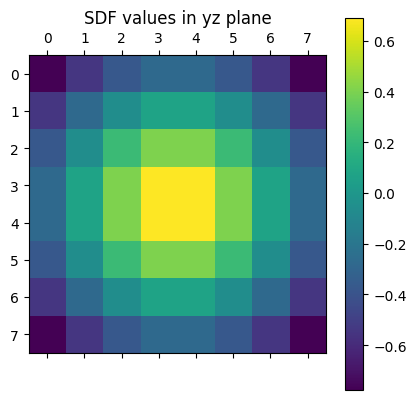

In [9]:
sdf_vals = create_artificial_sphere_sdf(voxel_coordinates, radius)

cut_img = sdf_vals[int(test_grid_size / 2), ..., 0]
plt.matshow(cut_img)
plt.colorbar()
plt.title("SDF values in yz plane")
plt.show()

To apply the marching cubes algorithm we first need to establish some conventions. 
We start by looking at the vertices (red numbers) and eges (blue) for an example cube.

![title](marching_cubes_cube.png)

For the algorithm to work, we need some lookup tables:
The first one, called ```LUT_EDGE_IDX_TO_START_END_POINTS_IDXS``` is provided.
Can you guess what it does?
...
If you look at it's entry for index 0, it will give you the tuple (0, 1). This means that the cube edge 0 (blue) starts at the corner 0 (red) and ends at the corner index 1 (red).


In [10]:

LUT_EDGE_IDX_TO_START_END_POINTS_IDXS = [
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 0),
    (4, 5),
    (5, 6),
    (6, 7),
    (7, 4),
    (0, 4),
    (1, 5),
    (2, 6),
    (3, 7),
]


In the lecture you have learned that there are 256 possible scenarios that can occur when fitting triangles to the SDF values.
We thus need a table with 256 entries, that will match one of these cases to some triangles.
A triangle is defined as a tuple of cube corner indices (red).
For example ```LUT_CUBE_IDX_TO_TRIANGLES_EDGE_IDXS[1]=[(0, 8, 3)]```: This means that for case 1, we need one triangle that has its vertices the edges 0,8,3 (blue!). 

Thankfully this table is in the public domain and we can just grab it.

In [11]:
# adapted from: http://paulbourke.net/geometry/polygonise/marchingsource.cpp
# (PUBLIC DOMAIN)
# Changes: Stripped "-1" dummy values from struct, don't need them here
LUT_CUBE_IDX_TO_TRIANGLES_EDGE_IDXS = [
    [],
    [(0, 8, 3)],
    [(0, 1, 9)],
    [(1, 8, 3), (9, 8, 1)],
    [(1, 2, 10)],
    [(0, 8, 3), (1, 2, 10)],
    [(10, 9, 0), (0, 2, 10)],
    [(2, 8, 3), (2, 10, 8), (10, 9, 8)],
    [(3, 11, 2)],
    [(2, 0, 8), (8, 11, 2)],
    [(1, 9, 0), (2, 3, 11)],
    [(1, 11, 2), (1, 9, 11), (9, 8, 11)],
    [(3, 11, 1), (1, 11, 10)],
    [(0, 10, 1), (0, 8, 10), (11, 10, 8)],
    [(3, 9, 0), (3, 11, 9), (11, 10, 9)],
    [(9, 8, 11), (10, 9, 11)],
    [(4, 7, 8)],
    [(4, 3, 0), (7, 3, 4)],
    [(0, 1, 9), (8, 4, 7)],
    [(4, 1, 9), (4, 7, 1), (7, 3, 1)],
    [(1, 2, 10), (8, 4, 7)],
    [(3, 4, 7), (3, 0, 4), (1, 2, 10)],
    [(9, 2, 10), (9, 0, 2), (8, 4, 7)],
    [(2, 10, 9), (2, 9, 7), (2, 7, 3), (7, 9, 4)],
    [(8, 4, 7), (3, 11, 2)],
    [(11, 4, 7), (11, 2, 4), (2, 0, 4)],
    [(9, 0, 1), (8, 4, 7), (2, 3, 11)],
    [(4, 7, 11), (9, 4, 11), (9, 11, 2), (2, 1, 9)],
    [(3, 11, 10), (10, 1, 3), (7, 8, 4)],
    [(11, 10, 1), (4, 11, 1), (7, 11, 4), (4, 1, 0)],
    [(4, 7, 8), (3, 11, 9), (9, 11, 10), (9, 0, 3)],
    [(4, 7, 11), (4, 11, 9), (9, 11, 10)],
    [(9, 5, 4)],
    [(9, 5, 4), (0, 8, 3)],
    [(0, 5, 4), (1, 5, 0)],
    [(8, 5, 4), (8, 3, 5), (3, 1, 5)],
    [(1, 2, 10), (9, 5, 4)],
    [(3, 0, 8), (1, 2, 10), (4, 9, 5)],
    [(5, 2, 10), (5, 4, 2), (4, 0, 2)],
    [(2, 10, 5), (3, 2, 5), (3, 5, 4), (3, 4, 8)],
    [(9, 5, 4), (2, 3, 11)],
    [(0, 11, 2), (0, 8, 11), (4, 9, 5)],
    [(0, 5, 4), (0, 1, 5), (2, 3, 11)],
    [(2, 1, 5), (2, 5, 8), (2, 8, 11), (4, 8, 5)],
    [(10, 3, 11), (10, 1, 3), (9, 5, 4)],
    [(4, 9, 5), (0, 8, 1), (8, 10, 1), (8, 11, 10)],
    [(5, 4, 0), (5, 0, 11), (5, 11, 10), (11, 0, 3)],
    [(5, 4, 8), (5, 8, 10), (10, 8, 11)],
    [(9, 7, 8), (5, 7, 9)],
    [(9, 3, 0), (9, 5, 3), (5, 7, 3)],
    [(0, 7, 8), (0, 1, 7), (1, 5, 7)],
    [(1, 5, 3), (3, 5, 7)],
    [(9, 7, 8), (9, 5, 7), (10, 1, 2)],
    [(10, 1, 2), (9, 5, 0), (5, 3, 0), (5, 7, 3)],
    [(8, 0, 2), (8, 2, 5), (8, 5, 7), (10, 5, 2)],
    [(2, 10, 5), (2, 5, 3), (3, 5, 7)],
    [(7, 9, 5), (7, 8, 9), (3, 11, 2)],
    [(9, 5, 7), (9, 7, 2), (9, 2, 0), (2, 7, 11)],
    [(2, 3, 11), (0, 1, 8), (1, 7, 8), (1, 5, 7)],
    [(11, 2, 1), (11, 1, 7), (7, 1, 5)],
    [(9, 5, 8), (8, 5, 7), (10, 1, 3), (10, 3, 11)],
    [(5, 7, 0), (5, 0, 9), (7, 11, 0), (1, 0, 10), (11, 10, 0)],
    [(11, 10, 0), (11, 0, 3), (10, 5, 0), (8, 0, 7), (5, 7, 0)],
    [(5, 11, 10), (11, 5, 7)],
    [(10, 6, 5)],
    [(0, 8, 3), (6, 5, 10)],
    [(9, 0, 1), (5, 10, 6)],
    [(1, 8, 3), (1, 9, 8), (5, 10, 6)],
    [(1, 6, 5), (2, 6, 1)],
    [(1, 6, 5), (1, 2, 6), (3, 0, 8)],
    [(9, 6, 5), (9, 0, 6), (0, 2, 6)],
    [(5, 9, 8), (5, 8, 2), (5, 2, 6), (3, 2, 8)],
    [(2, 3, 11), (10, 6, 5)],
    [(11, 0, 8), (11, 2, 0), (10, 6, 5)],
    [(0, 1, 9), (2, 3, 11), (5, 10, 6)],
    [(5, 10, 6), (1, 9, 2), (9, 11, 2), (9, 8, 11)],
    [(6, 3, 11), (6, 5, 3), (5, 1, 3)],
    [(0, 8, 11), (0, 11, 5), (0, 5, 1), (5, 11, 6)],
    [(3, 11, 6), (0, 3, 6), (0, 6, 5), (0, 5, 9)],
    [(6, 5, 9), (6, 9, 11), (11, 9, 8)],
    [(5, 10, 6), (4, 7, 8)],
    [(4, 3, 0), (4, 7, 3), (6, 5, 10)],
    [(1, 9, 0), (5, 10, 6), (8, 4, 7)],
    [(10, 6, 5), (1, 9, 7), (1, 7, 3), (7, 9, 4)],
    [(6, 1, 2), (6, 5, 1), (4, 7, 8)],
    [(1, 2, 5), (5, 2, 6), (3, 0, 4), (3, 4, 7)],
    [(8, 4, 7), (9, 0, 5), (0, 6, 5), (0, 2, 6)],
    [(7, 3, 9), (7, 9, 4), (3, 2, 9), (5, 9, 6), (2, 6, 9)],
    [(3, 11, 2), (7, 8, 4), (10, 6, 5)],
    [(5, 10, 6), (4, 7, 2), (4, 2, 0), (2, 7, 11)],
    [(0, 1, 9), (4, 7, 8), (2, 3, 11), (5, 10, 6)],
    [(9, 2, 1), (9, 11, 2), (9, 4, 11), (7, 11, 4), (5, 10, 6)],
    [(8, 4, 7), (3, 11, 5), (3, 5, 1), (5, 11, 6)],
    [(5, 1, 11), (5, 11, 6), (1, 0, 11), (7, 11, 4), (0, 4, 11)],
    [(0, 5, 9), (0, 6, 5), (0, 3, 6), (11, 6, 3), (8, 4, 7)],
    [(6, 5, 9), (6, 9, 11), (4, 7, 9), (7, 11, 9)],
    [(6, 4, 9), (9, 10, 6)],
    [(4, 10, 6), (4, 9, 10), (0, 8, 3)],
    [(10, 0, 1), (10, 6, 0), (6, 4, 0)],
    [(8, 3, 1), (8, 1, 6), (8, 6, 4), (6, 1, 10)],
    [(1, 4, 9), (1, 2, 4), (2, 6, 4)],
    [(3, 0, 8), (1, 2, 9), (2, 4, 9), (2, 6, 4)],
    [(0, 2, 4), (4, 2, 6)],
    [(8, 3, 2), (8, 2, 4), (4, 2, 6)],
    [(10, 4, 9), (10, 6, 4), (11, 2, 3)],
    [(0, 8, 2), (2, 8, 11), (4, 9, 10), (4, 10, 6)],
    [(3, 11, 2), (0, 1, 6), (0, 6, 4), (6, 1, 10)],
    [(6, 4, 1), (6, 1, 10), (4, 8, 1), (2, 1, 11), (8, 11, 1)],
    [(9, 6, 4), (9, 3, 6), (9, 1, 3), (11, 6, 3)],
    [(8, 11, 1), (8, 1, 0), (11, 6, 1), (9, 1, 4), (6, 4, 1)],
    [(3, 11, 6), (3, 6, 0), (0, 6, 4)],
    [(6, 4, 8), (8, 11, 6)],
    [(7, 10, 6), (7, 8, 10), (8, 9, 10)],
    [(0, 7, 3), (0, 10, 7), (0, 9, 10), (6, 7, 10)],
    [(10, 6, 7), (1, 10, 7), (1, 7, 8), (1, 8, 0)],
    [(10, 6, 7), (10, 7, 1), (1, 7, 3)],
    [(1, 2, 6), (1, 6, 8), (1, 8, 9), (8, 6, 7)],
    [(2, 6, 9), (2, 9, 1), (6, 7, 9), (0, 9, 3), (7, 3, 9)],
    [(7, 8, 0), (7, 0, 6), (6, 0, 2)],
    [(7, 3, 2), (6, 7, 2)],
    [(2, 3, 11), (10, 6, 8), (10, 8, 9), (8, 6, 7)],
    [(2, 0, 7), (2, 7, 11), (0, 9, 7), (6, 7, 10), (9, 10, 7)],
    [(1, 8, 0), (1, 7, 8), (1, 10, 7), (6, 7, 10), (2, 3, 11)],
    [(11, 2, 1), (11, 1, 7), (10, 6, 1), (6, 7, 1)],
    [(8, 9, 6), (8, 6, 7), (9, 1, 6), (11, 6, 3), (1, 3, 6)],
    [(0, 9, 1), (11, 6, 7)],
    [(7, 8, 0), (7, 0, 6), (3, 11, 0), (11, 6, 0)],
    [(7, 11, 6)],
    [(7, 6, 11)],
    [(3, 0, 8), (11, 7, 6)],
    [(0, 1, 9), (11, 7, 6)],
    [(8, 1, 9), (8, 3, 1), (11, 7, 6)],
    [(10, 1, 2), (6, 11, 7)],
    [(1, 2, 10), (3, 0, 8), (6, 11, 7)],
    [(2, 9, 0), (2, 10, 9), (6, 11, 7)],
    [(6, 11, 7), (2, 10, 3), (10, 8, 3), (10, 9, 8)],
    [(7, 2, 3), (6, 2, 7)],
    [(7, 0, 8), (7, 6, 0), (6, 2, 0)],
    [(2, 7, 6), (2, 3, 7), (0, 1, 9)],
    [(1, 6, 2), (1, 8, 6), (1, 9, 8), (8, 7, 6)],
    [(10, 7, 6), (10, 1, 7), (1, 3, 7)],
    [(10, 7, 6), (1, 7, 10), (1, 8, 7), (1, 0, 8)],
    [(0, 3, 7), (0, 7, 10), (0, 10, 9), (6, 10, 7)],
    [(7, 6, 10), (7, 10, 8), (8, 10, 9)],
    [(8, 4, 6), (6, 11, 8)],
    [(3, 6, 11), (3, 0, 6), (0, 4, 6)],
    [(8, 6, 11), (8, 4, 6), (9, 0, 1)],
    [(9, 4, 6), (9, 6, 3), (9, 3, 1), (11, 3, 6)],
    [(6, 8, 4), (6, 11, 8), (2, 10, 1)],
    [(1, 2, 10), (3, 0, 11), (0, 6, 11), (0, 4, 6)],
    [(4, 11, 8), (4, 6, 11), (0, 2, 9), (2, 10, 9)],
    [(10, 9, 3), (10, 3, 2), (9, 4, 3), (11, 3, 6), (4, 6, 3)],
    [(8, 2, 3), (8, 4, 2), (4, 6, 2)],
    [(0, 4, 2), (4, 6, 2)],
    [(1, 9, 0), (2, 3, 4), (2, 4, 6), (4, 3, 8)],
    [(1, 9, 4), (1, 4, 2), (2, 4, 6)],
    [(8, 1, 3), (8, 6, 1), (8, 4, 6), (6, 10, 1)],
    [(10, 1, 0), (10, 0, 6), (6, 0, 4)],
    [(4, 6, 3), (4, 3, 8), (6, 10, 3), (0, 3, 9), (10, 9, 3)],
    [(10, 9, 4), (4, 6, 10)],
    [(4, 9, 5), (7, 6, 11)],
    [(0, 8, 3), (4, 9, 5), (11, 7, 6)],
    [(5, 0, 1), (5, 4, 0), (7, 6, 11)],
    [(11, 7, 6), (8, 3, 4), (3, 5, 4), (3, 1, 5)],
    [(9, 5, 4), (10, 1, 2), (7, 6, 11)],
    [(6, 11, 7), (1, 2, 10), (0, 8, 3), (4, 9, 5)],
    [(7, 6, 11), (5, 4, 10), (4, 2, 10), (4, 0, 2)],
    [(3, 4, 8), (3, 5, 4), (3, 2, 5), (10, 5, 2), (11, 7, 6)],
    [(7, 2, 3), (7, 6, 2), (5, 4, 9)],
    [(9, 5, 4), (0, 8, 6), (0, 6, 2), (6, 8, 7)],
    [(3, 6, 2), (3, 7, 6), (1, 5, 0), (5, 4, 0)],
    [(6, 2, 8), (6, 8, 7), (2, 1, 8), (4, 8, 5), (1, 5, 8)],
    [(9, 5, 4), (10, 1, 6), (1, 7, 6), (1, 3, 7)],
    [(1, 6, 10), (1, 7, 6), (1, 0, 7), (8, 7, 0), (9, 5, 4)],
    [(4, 0, 10), (4, 10, 5), (0, 3, 10), (6, 10, 7), (3, 7, 10)],
    [(7, 6, 10), (7, 10, 8), (5, 4, 10), (4, 8, 10)],
    [(6, 9, 5), (6, 11, 9), (11, 8, 9)],
    [(3, 6, 11), (0, 6, 3), (0, 5, 6), (0, 9, 5)],
    [(0, 11, 8), (0, 5, 11), (0, 1, 5), (5, 6, 11)],
    [(6, 11, 3), (6, 3, 5), (5, 3, 1)],
    [(1, 2, 10), (9, 5, 11), (9, 11, 8), (11, 5, 6)],
    [(0, 11, 3), (0, 6, 11), (0, 9, 6), (5, 6, 9), (1, 2, 10)],
    [(11, 8, 5), (11, 5, 6), (8, 0, 5), (10, 5, 2), (0, 2, 5)],
    [(6, 11, 3), (6, 3, 5), (2, 10, 3), (10, 5, 3)],
    [(5, 8, 9), (5, 2, 8), (5, 6, 2), (3, 8, 2)],
    [(9, 5, 6), (9, 6, 0), (0, 6, 2)],
    [(1, 5, 8), (1, 8, 0), (5, 6, 8), (3, 8, 2), (6, 2, 8)],
    [(1, 5, 6), (2, 1, 6)],
    [(1, 3, 6), (1, 6, 10), (3, 8, 6), (5, 6, 9), (8, 9, 6)],
    [(10, 1, 0), (10, 0, 6), (9, 5, 0), (5, 6, 0)],
    [(0, 3, 8), (5, 6, 10)],
    [(5, 6, 10)],
    [(11, 5, 10), (7, 5, 11)],
    [(11, 5, 10), (11, 7, 5), (8, 3, 0)],
    [(5, 11, 7), (5, 10, 11), (1, 9, 0)],
    [(10, 7, 5), (10, 11, 7), (9, 8, 1), (8, 3, 1)],
    [(11, 1, 2), (11, 7, 1), (7, 5, 1)],
    [(0, 8, 3), (1, 2, 7), (1, 7, 5), (7, 2, 11)],
    [(9, 7, 5), (9, 2, 7), (9, 0, 2), (2, 11, 7)],
    [(7, 5, 2), (7, 2, 11), (5, 9, 2), (3, 2, 8), (9, 8, 2)],
    [(2, 5, 10), (2, 3, 5), (3, 7, 5)],
    [(8, 2, 0), (8, 5, 2), (8, 7, 5), (10, 2, 5)],
    [(9, 0, 1), (5, 10, 3), (5, 3, 7), (3, 10, 2)],
    [(9, 8, 2), (9, 2, 1), (8, 7, 2), (10, 2, 5), (7, 5, 2)],
    [(1, 3, 5), (3, 7, 5)],
    [(0, 8, 7), (0, 7, 1), (1, 7, 5)],
    [(9, 0, 3), (9, 3, 5), (5, 3, 7)],
    [(9, 8, 7), (5, 9, 7)],
    [(5, 8, 4), (5, 10, 8), (10, 11, 8)],
    [(5, 0, 4), (5, 11, 0), (5, 10, 11), (11, 3, 0)],
    [(0, 1, 9), (8, 4, 10), (8, 10, 11), (10, 4, 5)],
    [(10, 11, 4), (10, 4, 5), (11, 3, 4), (9, 4, 1), (3, 1, 4)],
    [(2, 5, 1), (2, 8, 5), (2, 11, 8), (4, 5, 8)],
    [(0, 4, 11), (0, 11, 3), (4, 5, 11), (2, 11, 1), (5, 1, 11)],
    [(0, 2, 5), (0, 5, 9), (2, 11, 5), (4, 5, 8), (11, 8, 5)],
    [(9, 4, 5), (2, 11, 3)],
    [(2, 5, 10), (3, 5, 2), (3, 4, 5), (3, 8, 4)],
    [(5, 10, 2), (5, 2, 4), (4, 2, 0)],
    [(3, 10, 2), (3, 5, 10), (3, 8, 5), (4, 5, 8), (0, 1, 9)],
    [(5, 10, 2), (5, 2, 4), (1, 9, 2), (9, 4, 2)],
    [(8, 4, 5), (8, 5, 3), (3, 5, 1)],
    [(0, 4, 5), (1, 0, 5)],
    [(8, 4, 5), (8, 5, 3), (9, 0, 5), (0, 3, 5)],
    [(9, 4, 5)],
    [(4, 11, 7), (4, 9, 11), (9, 10, 11)],
    [(0, 8, 3), (4, 9, 7), (9, 11, 7), (9, 10, 11)],
    [(1, 10, 11), (1, 11, 4), (1, 4, 0), (7, 4, 11)],
    [(3, 1, 4), (3, 4, 8), (1, 10, 4), (7, 4, 11), (10, 11, 4)],
    [(4, 11, 7), (9, 11, 4), (9, 2, 11), (9, 1, 2)],
    [(9, 7, 4), (9, 11, 7), (9, 1, 11), (2, 11, 1), (0, 8, 3)],
    [(11, 7, 4), (11, 4, 2), (2, 4, 0)],
    [(11, 7, 4), (11, 4, 2), (8, 3, 4), (3, 2, 4)],
    [(2, 9, 10), (2, 7, 9), (2, 3, 7), (7, 4, 9)],
    [(9, 10, 7), (9, 7, 4), (10, 2, 7), (8, 7, 0), (2, 0, 7)],
    [(3, 7, 10), (3, 10, 2), (7, 4, 10), (1, 10, 0), (4, 0, 10)],
    [(1, 10, 2), (8, 7, 4)],
    [(4, 9, 1), (4, 1, 7), (7, 1, 3)],
    [(4, 9, 1), (4, 1, 7), (0, 8, 1), (8, 7, 1)],
    [(4, 0, 3), (7, 4, 3)],
    [(4, 8, 7)],
    [(9, 11, 8), (11, 9, 10)],
    [(3, 0, 9), (3, 9, 11), (11, 9, 10)],
    [(0, 1, 10), (0, 10, 8), (8, 10, 11)],
    [(3, 1, 11), (11, 1, 10)],
    [(1, 2, 11), (1, 11, 9), (9, 11, 8)],
    [(3, 0, 9), (3, 9, 11), (1, 2, 9), (2, 11, 9)],
    [(0, 2, 11), (11, 8, 0)],
    [(3, 2, 11)],
    [(2, 3, 8), (2, 8, 10), (10, 8, 9)],
    [(2, 0, 9), (9, 10, 2)],
    [(2, 3, 8), (2, 8, 10), (0, 1, 8), (1, 10, 8)],
    [(10, 2, 1)],
    [(1, 3, 8), (9, 1, 8)],
    [(0, 9, 1)],
    [(3, 8, 0)],
    [],
]

We are also going to need some code to interpolate the location of a triangle vertex on an edge:
x1, x2 are the coordinates of the box corner locations in 3D.
The solution for the interpolation is given in the lecture slides.



In [12]:
def interpolate_crossing(loc_x1, sdf_val_at_x1, loc_x2, sdf_val_at_x2, thresh=0.0):
    # avoid divison by zero
    if sdf_val_at_x1 == sdf_val_at_x2:
        crossing_location = (loc_x2 + loc_x1) / 2
    else:
    # BEGIN REGION SOLUTION
    # interpolate here
        a = (thresh - sdf_val_at_x1) / (sdf_val_at_x2 - sdf_val_at_x1)
        crossing_location = loc_x1 + a * (loc_x2 - loc_x1)
    # END REGION SOLUTION
        pass
    return crossing_location


Next, we write a convenience method ```get_map_box_corner_idx_to_coords_tuple```, that will help us to get the voxel indices for each box corner. This means that ```map_box_corner_idx_to_coords_tuple``` maps a box corner idx (red) to a tuple of coordinates:

For the first two box corner indexes the solution is already provided. Fill in the coordinate tuples for the remaining coordinate tuples.

![title](marching_cubes_cube.png)


If all of that was a bit much, I suggest you read the excellent blog post here: [Polygonising a scalar field](http://paulbourke.net/geometry/polygonise/)


IMPORTANT: The only place you need to modify here is the ```map_box_corner_idx_to_coords_tuple``` dict.

In [13]:
def get_map_box_corner_idx_to_coords_tuple(x_idx, y_idx, z_idx): 
    map_box_corner_idx_to_coords_tuple = {
        0: (x_idx, y_idx, z_idx),
        1: (x_idx, y_idx + 1, z_idx),
        # BEGIN REGION SOLUTION: fill in the missing cases
        2: (x_idx + 1, y_idx + 1, z_idx),
        3: (x_idx + 1, y_idx, z_idx),
        4: (x_idx, y_idx, z_idx + 1),
        5: (x_idx, y_idx + 1, z_idx + 1),
        6: (x_idx + 1, y_idx + 1, z_idx + 1),
        7: (x_idx + 1, y_idx, z_idx + 1),
        # END REGION SOLUTION
    }

    assert len(map_box_corner_idx_to_coords_tuple) == 8, "you missed some cases or added too many"
    return map_box_corner_idx_to_coords_tuple

Finally we can write out the marching cubes method. The marching_cubes method goes over all cells in the voxel grid, identifies the correct one out of the 256 cases. Then it looks at the corresponding edge tuples of all triangles in LUT_CUBE_IDX_TO_TRIANGLES_EDGE_IDXS.

For each edge your interpolation code is applied. And the resulting triangle vertex will be stored. You don't need to modify anything here.

In [14]:
def marching_cubes(sdf_field, voxel_coords, thresh=0.0):
    assert sdf_field.shape[:-1] == voxel_coords.shape[:-1]
    triangle_vertices = []
    for x_idx in range(sdf_field.shape[0] - 1):
        for y_idx in range(sdf_field.shape[1] - 1):
            for z_idx in range(sdf_field.shape[2] - 1):

                map_box_corner_idx_to_coords_tuple = get_map_box_corner_idx_to_coords_tuple(x_idx, y_idx, z_idx)

                # 256 possible cases -> we need to match the correct case
                cube_lut_index = 0
                if sdf_field[map_box_corner_idx_to_coords_tuple[0]] < thresh:
                    cube_lut_index |= 1
                if sdf_field[map_box_corner_idx_to_coords_tuple[1]] < thresh:
                    cube_lut_index |= 2
                if sdf_field[map_box_corner_idx_to_coords_tuple[2]] < thresh:
                    cube_lut_index |= 4
                if sdf_field[map_box_corner_idx_to_coords_tuple[3]] < thresh:
                    cube_lut_index |= 8
                if sdf_field[map_box_corner_idx_to_coords_tuple[4]] < thresh:
                    cube_lut_index |= 16
                if sdf_field[map_box_corner_idx_to_coords_tuple[5]] < thresh:
                    cube_lut_index |= 32
                if sdf_field[map_box_corner_idx_to_coords_tuple[6]] < thresh:
                    cube_lut_index |= 64
                if sdf_field[map_box_corner_idx_to_coords_tuple[7]] < thresh:
                    cube_lut_index |= 128

                for edge_tuple_1, edge_tuple_2, edge_tuple_3 in LUT_CUBE_IDX_TO_TRIANGLES_EDGE_IDXS[cube_lut_index]:
                    vertices = []
                    for edge in (edge_tuple_1, edge_tuple_2, edge_tuple_3):
                        (
                            edge_start_point,
                            edge_end_point,
                        ) = LUT_EDGE_IDX_TO_START_END_POINTS_IDXS[edge]

                        start_point = voxel_coords[map_box_corner_idx_to_coords_tuple[edge_start_point]]
                        end_point = voxel_coords[map_box_corner_idx_to_coords_tuple[edge_end_point]]
                        
                        vertex = interpolate_crossing(
                            start_point,
                            sdf_field[map_box_corner_idx_to_coords_tuple[edge_start_point]],
                            end_point,
                            sdf_field[map_box_corner_idx_to_coords_tuple[edge_end_point]],
                            thresh,
                        )
                        vertices.append(vertex)
                    triangle_vertices.append(vertices)
    triangle_vertices = np.array(triangle_vertices)

    return triangle_vertices.astype(np.float32)

Let's add a quick visu function: (You don't need to modify this.)

In [15]:
def plot_mesh(tri_vertices):    
    
    faces = []
    for i, t in enumerate(tri_vertices):
        faces.append([i * 3, i * 3 + 2, i * 3 + 1])

    plot = k3d.plot()
    
    mesh = k3d.mesh(tri_vertices, faces)

    plot += mesh

    plot.display()

In [16]:
def plot_mesh_colab(tri_vertices):

    faces = []
    triangle_vertices = tri_vertices.reshape((-1,3))
    for i, t in enumerate(tri_vertices):
        if i % 3 == 0:
            faces.append([i, i+2, i+1])
    faces = np.array(faces)

    mymesh = Trimesh(triangle_vertices, faces)

    mymesh.show(smooth=False)

For technical reasons, we need to use different methods to plot the mesh when we are in colab / on our local machine. Use ```plot_mesh_colab``` when working on Google Colab and ```plot_mesh``` elsewhere.

In [17]:
triangle_vertices = marching_cubes(sdf_vals, voxel_coordinates, thresh=0.0)



In [18]:
# please comment out the next line if you are running on google colab
plot_mesh(triangle_vertices)

# please comment out the next line if you are running on your local machine
plot_mesh_colab(triangle_vertices)

Output()

Depending on which viewer you use, you should be seeing something like this:

![title](reconstruction_view.png)

In order to compare our reconstructed mesh, we want to compare it to some randomly sampled points on the same sphere as above: 

In [22]:

def random_points_on_sphere(radius, num_points, center=np.array([0.0, 0.0, 0.0])):

    # BEGIN REGION SOLUTION
    points = np.random.normal(size=(num_points, 3))
    points = points / np.linalg.norm(points, axis=1, keepdims=True)
    points = points * radius + center
  
    # END REGION SOLUTION

    assert points.shape == (num_points, 3)
    return points


Let's once again take a look. If you have done it correctly, there should be no bias towards the poles of the sphere.

In [23]:
def plot_points(points):
    plot = k3d.plot()
    plot += k3d.points(gt_points[::10, 0:3], point_size=0.01)
    plot.display()

def plot_points_colab(points):

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(points[::25,0], points[::25,1], points[::25,2])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    scaling = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    ax.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3) 

    plt.show()

/Users/haddless/opt/anaconda3/envs/lecturecv/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

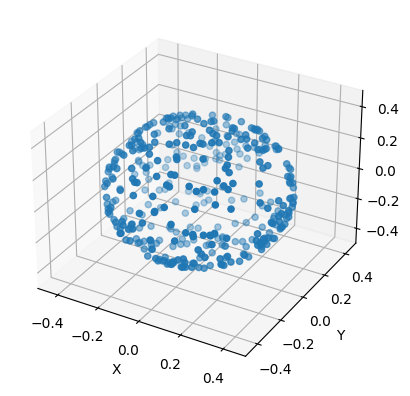

In [24]:
gt_points = random_points_on_sphere(radius=radius, num_points=10000)

# if you run locally use this (nicer, interactive plot)
plot_points(gt_points)

# if you are running on colab:
plot_points_colab(gt_points)

Now, we are going to implement one of the most important metrics when it comes to 3D reconstruction.
It takes two point clouds $X$ and $Y$ (each one unordered set of points) and computes the mean minimum distance from one point cloud to the other one and in reverse:
 
The Chamfer Distance is defined as follows:

$ d = 0.5 \cdot (\frac{1}{\left | X \right |}\sum_{x_i \in X}{\min_{y_j \in Y}{||x_i-y_j||^2}} + \frac{1}{\left | Y \right |} \sum_{y_j \in Y}{\min_{x_i \in X}{||x_i-y_j||^2}})$

This allows us to judge how close one point cloud is on average to the other.

Hint: Use the KDTree (already imported) to get the nearest neighbors of one point cloud to the other! 
[KDTree Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html#scipy.spatial.KDTree)

In [36]:
def chamfer_distance(pcl_0, pcl_1):
    assert pcl_1.shape[-1] == 3
    assert pcl_0.shape[-1] == 3
    # BEGIN REGION SOLUTION
    # compute chamfer distance here
    tree = KDTree(pcl_0)
    dist_0 = tree.query(pcl_1)[0].mean()
    tree = KDTree(pcl_1)
    dist_1 = tree.query(pcl_0)[0].mean()

    chamfer_dist = dist_0 + dist_1
    chamfer_dist = float(chamfer_dist)/2
    # END REGION SOLUTION

    assert type(chamfer_dist) == float
    return chamfer_dist

We're almost there! Let's compare the runtimes and chamfer distances for different grid sizes. You do not need to modify anything here. Please be patient, this might take a couple of seconds.

In [37]:
metrics = defaultdict(list)
for grid_size in [8, 16, 32, 64, 128]:
    print("Processing grid size: {0}...".format(grid_size))
    voxel_coordinates = create_voxel_coords_grid(size_x, grid_size, size_y, size_z)

    sdf_vals = create_artificial_sphere_sdf(voxel_coordinates, radius)

    time_start = perf_counter()
    triangle_vertices = marching_cubes(sdf_vals, voxel_coordinates)
    runtime = perf_counter() - time_start
    triangle_vertex_centers = np.mean(triangle_vertices, axis=-2)

    metrics["Grid Size"].append(grid_size)
    metrics["time"].append(runtime)
    metrics["Chamfer Distance"].append(
        chamfer_distance(gt_points, triangle_vertex_centers)
    )
print("Done!")

Processing grid size: 8...
Processing grid size: 16...
Processing grid size: 32...
Processing grid size: 64...
Processing grid size: 128...
Done!


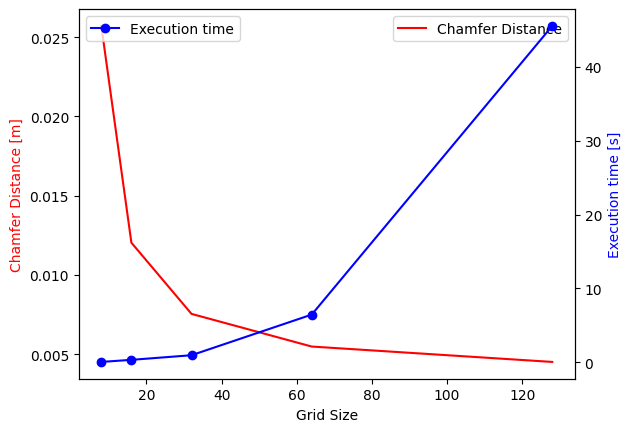

Success!


In [38]:
fig, ax = plt.subplots()
ax.plot(
    metrics["Grid Size"],
    metrics["Chamfer Distance"],
    label="Chamfer Distance",
    color="red",
)
ax.set_xlabel("Grid Size")
ax.set_ylabel("Chamfer Distance [m]", color="red")
plt.legend()
ax2 = ax.twinx()
ax2.plot(
    metrics["Grid Size"],
    metrics["time"],
    label="Execution time",
    color="blue",
    marker="o",
)
ax2.set_ylabel("Execution time [s]", color="blue")
plt.legend()
plt.show()
print("Success!")